<a href="https://colab.research.google.com/github/Dimas0824/Machine_Learning/blob/main/Jobsheet_6/Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 2



Pada percobaan kali ini kita akan membuat pencarian sederhana menggunakan FAISS. Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.

In [5]:
!pip install faiss-cpu
#!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 32.4 MB/s eta 0:00:00


Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.00016617774963378906
Waktu IVF+PQ: 0.00020956993103027344


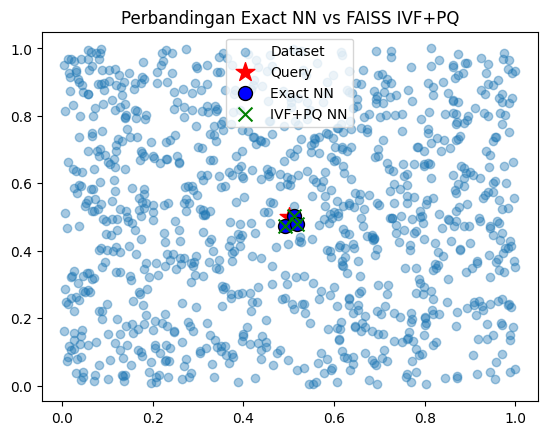

In [6]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

### 🔍 Perbandingan Hasil Exact NN vs Approx NN (FAISS)

| No | Jumlah Data | Dimensi | Metode | Indeks Terdekat | Jarak | Waktu (detik) |
|----|--------------|----------|---------|------------------|--------|----------------|
| 1 | 1,000 | 2D | **Exact NN (Flat)** | [137, 170, 750] | [0.00013095, 0.00077404, 0.00079751] | 0.000166 |
|   |              |          | **Approx NN (IVF+PQ)** | [137, 170, 750] | [0.00012945, 0.00079226, 0.00080067] | 0.000210 |
| 2 | 1,000,000 | 5D | **Exact NN (Flat)** | [901095, 495168, 561017, 163986, 185734] | [0.00151859, 0.00221511, 0.00223645, 0.00299811, 0.00363892] | 0.0143 |
|   |              |          | **Approx NN (IVF+PQ)** | [495168, 163986, 708238, 859369, 645966] | [0.00220674, 0.00303717, 0.00388362, 0.00430324, 0.00450503] | 0.0003 |


Training index IVF-PQ...


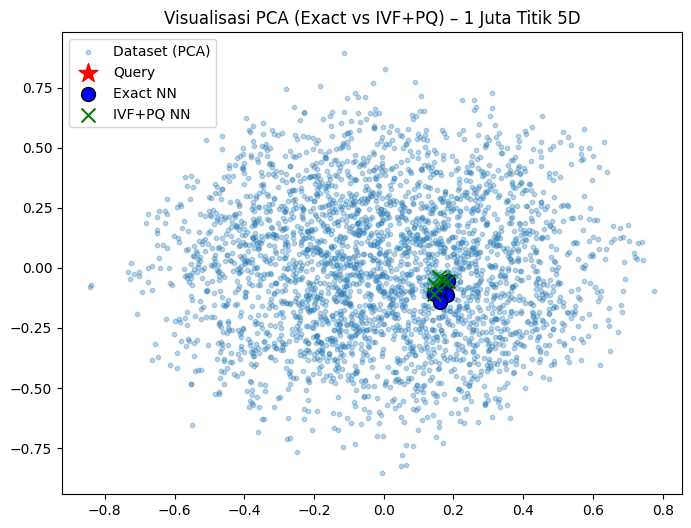


=== HASIL PERBANDINGAN ===
Exact NN (Flat) indices: [[901095 495168 561017 163986 185734]]
Exact NN distances: [[0.00151859 0.00221511 0.00223645 0.00299811 0.00363892]]
Approx NN (IVF+PQ) indices: [[495168 163986 708238 859369 645966]]
Approx NN distances: [[0.00220674 0.00303717 0.00388362 0.00430324 0.00450503]]
Waktu Exact NN  : 0.0143 detik
Waktu IVF+PQ ANN: 0.0003 detik


In [9]:
import numpy as np
import faiss
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Membuat Dataset 1 Juta Titik Berdimensi 5
# Set random seed agar hasil konsisten
np.random.seed(42)

n_data = 1_000_000   # jumlah data = 1 juta
dim = 5               # dimensi fitur

# Dataset acak 1 juta x 5
X = np.random.rand(n_data, dim).astype('float32')

# Query tunggal (misalnya titik tengah)
query = np.random.rand(1, dim).astype('float32')

# 2. Exact Nearest Neighbor (IndexFlatL2)
# Gunakan brute-force dengan L2 distance (Euclidean)
index_flat = faiss.IndexFlatL2(dim)
index_flat.add(X)  # tambahkan semua data ke index

start = time.time()
D_flat, I_flat = index_flat.search(query, 5)  # ambil 5 tetangga terdekat
time_flat = time.time() - start

# 3. Approximate Nearest Neighbor (IVF + PQ)
# nlist = jumlah cluster awal (semakin besar semakin akurat tapi lambat)
# m = jumlah subvector (harus habis membagi dim)
nlist = 100      # jumlah cluster
m = 5            # jumlah subvector (5 agar pas dengan dim=5)
bits = 8         # 8 bit per subvector

# Buat quantizer dan index IVF-PQ
quantizer = faiss.IndexFlatL2(dim)
index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, bits)

# Latih index berdasarkan data (hanya perlu sekali)
print("Training index IVF-PQ...")
index_ivfpq.train(X)

# Tambahkan semua data ke index
index_ivfpq.add(X)

# Cari 5 tetangga terdekat
start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 5)
time_ivfpq = time.time() - start

# 4. Visualisasi (PCA ke 2D)
# Ambil subset kecil (biar plot-nya ringan)
subset_idx = np.random.choice(len(X), 3000, replace=False)
X_subset = X[subset_idx]

# Lakukan PCA dari 5D → 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_subset)
query_2d = pca.transform(query)

# Tetangga terdekat (projek ke 2D juga)
flat_2d = pca.transform(X[I_flat[0]])
ivfpq_2d = pca.transform(X[I_ivfpq[0]])

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], s=10, alpha=0.3, label='Dataset (PCA)')
plt.scatter(query_2d[:,0], query_2d[:,1], c='red', marker='*', s=200, label='Query')

# Hasil Exact
plt.scatter(flat_2d[:,0], flat_2d[:,1], c='blue', s=100, edgecolor='k', label='Exact NN')

# Hasil IVF+PQ
plt.scatter(ivfpq_2d[:,0], ivfpq_2d[:,1], c='green', marker='x', s=100, label='IVF+PQ NN')

plt.title("Visualisasi PCA (Exact vs IVF+PQ) – 1 Juta Titik 5D")
plt.legend()
plt.show()

# 4. Tampilkan Hasil Perbandingan
print("\n=== HASIL PERBANDINGAN ===")
print("Exact NN (Flat) indices:", I_flat)
print("Exact NN distances:", D_flat)
print("Approx NN (IVF+PQ) indices:", I_ivfpq)
print("Approx NN distances:", D_ivfpq)
print(f"Waktu Exact NN  : {time_flat:.4f} detik")
print(f"Waktu IVF+PQ ANN: {time_ivfpq:.4f} detik")
